<a href="https://colab.research.google.com/github/hallpaz/3dsystems21/blob/main/assignments/LabClass4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Textures in Pytorch3D 
## Design and Implementation of 3D Graphics Systems - IMPA 2021
### Laboratory class #4

Material based on the course [An Introduction to PyTorch3D](https://sa2020.siggraph.org/en/attend/courses/session/2/details/5) given by the Facebook team at SIGGRAPH Asia 2020 ([check video here](https://youtu.be/MOBAJb5nJRI)).

In [1]:
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    786      0 --:--:-- --:--:-- --:--:--   786
100  404k    0  404k    0     0  1143k      0 --:--:-- --:--:-- --:--:-- 5918k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-67sfkxpf
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-67sfkxpf
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 645kB 26.2MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.4.0-cp37-cp37m-linux_x86_64.whl size=23225766 sha256=48a88587dc1c3477af4fee3d9666da01372df3757b61600714d369c1cd529b03
  Stored in directory: /tmp/pip-ephem-wheel-cache-fjg1hp09/wheels/89/69/08/d864f516508b5d943259c6088baa150eb

In [3]:
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
import tabulate
sys.path.append(os.path.abspath(''))

In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2021-04-19 14:19:05--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K   965KB/s    in 0.3s    

2021-04-19 14:19:06 (965 KB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2021-04-19 14:19:06--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[==============

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

In [9]:
earth_path = "/content/drive/MyDrive/s3d21/lab4/Terra.obj"
earth_mesh = load_objs_as_meshes([earth_path], device=device)

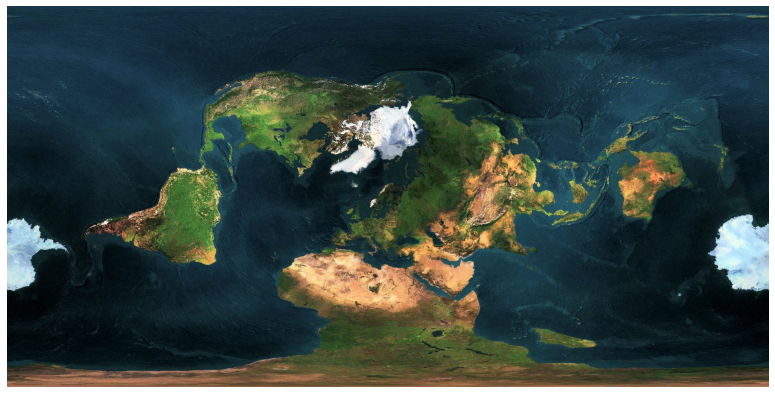

In [15]:
# Let's visualize the texture map
plt.figure(figsize=(14,7))
texture_image=earth_mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis("off");

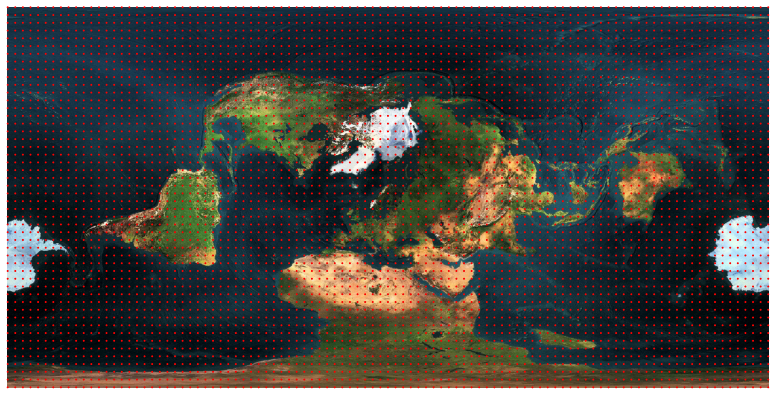

In [11]:
# PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices.
plt.figure(figsize=(14,7))
texturesuv_image_matplotlib(earth_mesh.textures, subsample=None)
plt.grid("off");
plt.axis("off");

In [12]:
wall_path = "/content/drive/MyDrive/s3d21/lab4/plane.obj"
wall_mesh = load_objs_as_meshes([wall_path], device=device)

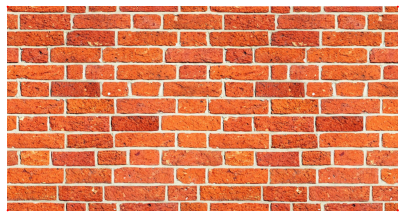

In [13]:
# PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices.
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(wall_mesh.textures, subsample=None)
plt.grid("off");
plt.axis("off");

In [6]:
# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

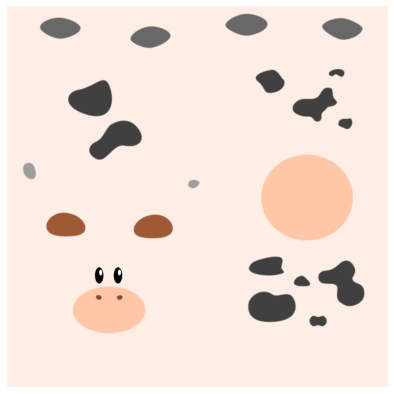

In [7]:
# Let's visualize the texture map
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis("off");

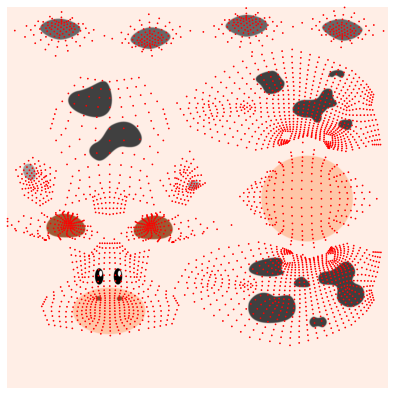

In [8]:
# PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices.
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.grid("off");
plt.axis("off");

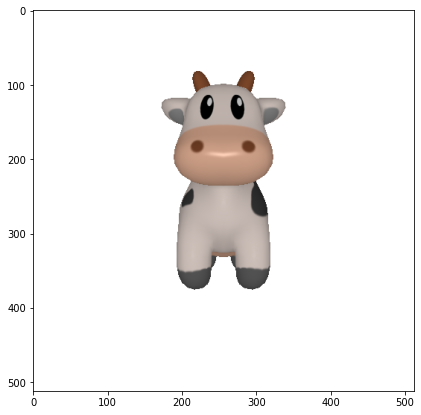

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(7, 7))
plt.imshow(images[0, ..., :3].cpu().numpy())

In [16]:
plot_batch_individually(mesh)

In [20]:
def show_mesh_info(mesh):
  print(f"mesh.verts_padded().shape = {mesh.verts_padded().shape}")
  print(f"mesh.faces_padded().shape = {mesh.faces_padded().shape}")
  print(f"mesh.textures.maps_padded().shape = {mesh.textures.maps_padded().shape}")
  print("--------")
  print("VERTS UVS:")
  print(f"mesh.textures.verts_uvs_padded().shape = {mesh.textures.verts_uvs_padded().shape}")
  print(mesh.textures.verts_uvs_padded()[0,:5])

  print("FACES UVS:")
  print(f"mesh.textures.faces_uvs_padded().shape = {mesh.textures.faces_uvs_padded().shape}")
  print(mesh.textures.faces_uvs_padded()[0,:5])

In [21]:
show_mesh_info(earth_mesh)

mesh.verts_padded().shape = torch.Size([1, 5050, 3])
mesh.faces_padded().shape = torch.Size([1, 9800, 3])
mesh.textures.maps_padded().shape = torch.Size([1, 800, 1600, 3])
--------
VERTS UVS:
mesh.textures.verts_uvs_padded().shape = torch.Size([1, 5050, 2])
tensor([[0.0000, 0.0000],
        [0.0100, 0.0000],
        [0.0200, 0.0000],
        [0.0300, 0.0000],
        [0.0400, 0.0000]], device='cuda:0')
FACES UVS:
mesh.textures.faces_uvs_padded().shape = torch.Size([1, 9800, 3])
tensor([[  0, 102, 101],
        [  0,   1, 102],
        [  1, 103, 102],
        [  1,   2, 103],
        [  2, 104, 103]], device='cuda:0')


In [38]:
show_mesh_info(mesh)

mesh.verts_padded().shape = torch.Size([1, 2930, 3])
mesh.faces_padded().shape = torch.Size([1, 5856, 3])
mesh.textures.maps_padded().shape = torch.Size([1, 1024, 1024, 3])
--------
VERTS UVS:
mesh.textures.verts_uvs_padded().shape = torch.Size([1, 3225, 2])
tensor([[0.8004, 0.6675],
        [0.7896, 0.6682],
        [0.7999, 0.6639],
        [0.7891, 0.6649],
        [0.8118, 0.6708]], device='cuda:0')
FACES UVS:
mesh.textures.faces_uvs_padded().shape = torch.Size([1, 5856, 3])
tensor([[0, 1, 2],
        [3, 2, 1],
        [4, 5, 6],
        [0, 6, 5],
        [7, 8, 9]], device='cuda:0')


### Some mesh manipulations

In [22]:
offset1 = mesh.verts_padded().new_tensor([0, 0.5, -0.5]).expand(mesh.verts_packed().shape)
offset2 = mesh.verts_padded().new_tensor([0, -0.5, 0]).expand(mesh.verts_packed().shape)
small_mesh = mesh.scale_verts(0.4).offset_verts_(offset1)

double_mesh = join_meshes_as_scene([mesh.clone().offset_verts_(offset2), small_mesh])
two_meshes = join_meshes_as_batch([mesh, double_mesh])

In [23]:
plot_batch_individually(two_meshes, ncols=2)

(-0.5, 2047.5, 1023.5, -0.5)

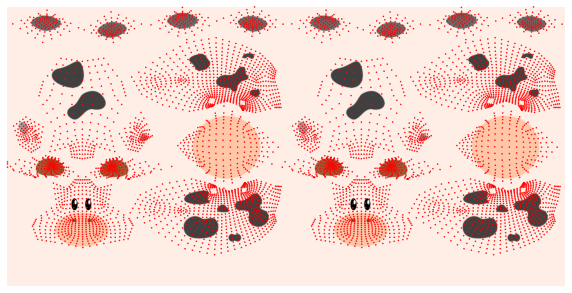

In [24]:
plt.figure(figsize=(10, 10))
texturesuv_image_matplotlib(double_mesh.textures)
plt.axis("off")

### Run the renderer on the batch

In [26]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

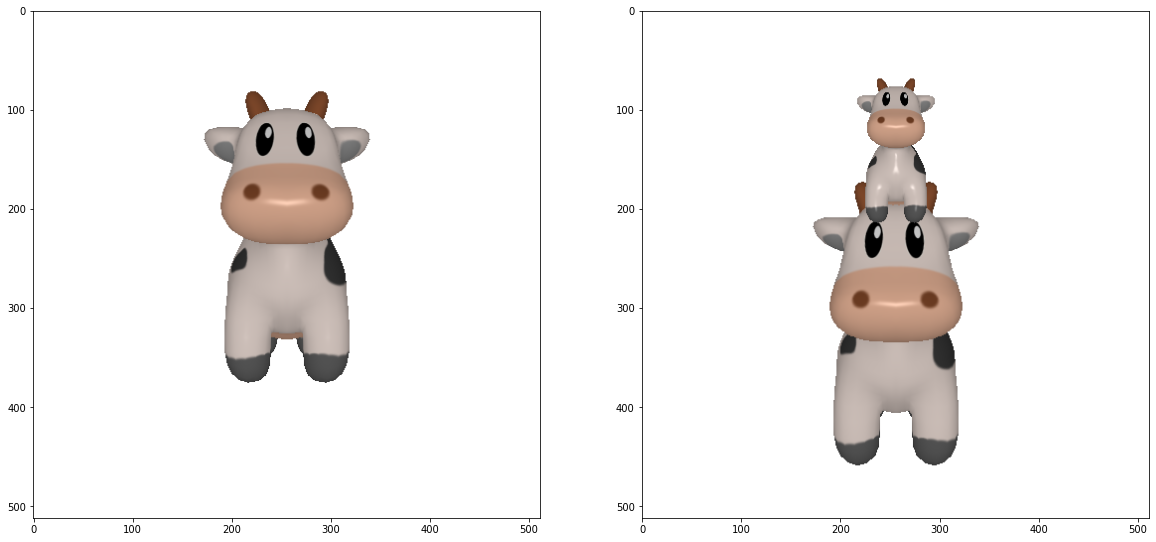

In [28]:
images = renderer(two_meshes)
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid(False)
plt.subplot(122)
plt.imshow(images[1, ..., :3].cpu().numpy())
plt.grid(False)

### TexturesVertex 
This is a second texture object where colors are stored for each vertex of the mesh and interpolated using barycentric coordinates

In [29]:
verts = mesh.verts_padded()[0]
print(verts.min(dim=0).values)
print(verts.max(dim=0).values)

tensor([-0.4716, -0.7368, -0.6689], device='cuda:0')
tensor([0.4716, 0.9536, 1.0490], device='cuda:0')


In [30]:
colors_gradient = verts*0.5 + 0.4
colors_random = torch.rand_like(colors_gradient)

In [31]:
textures_vertex = TexturesVertex([colors_gradient, colors_random])
vertex_colored_mesh = Meshes(verts=[verts, verts], faces=mesh.faces_list()*2, textures=textures_vertex)

In [32]:
plot_batch_individually(vertex_colored_mesh, ncols=2)

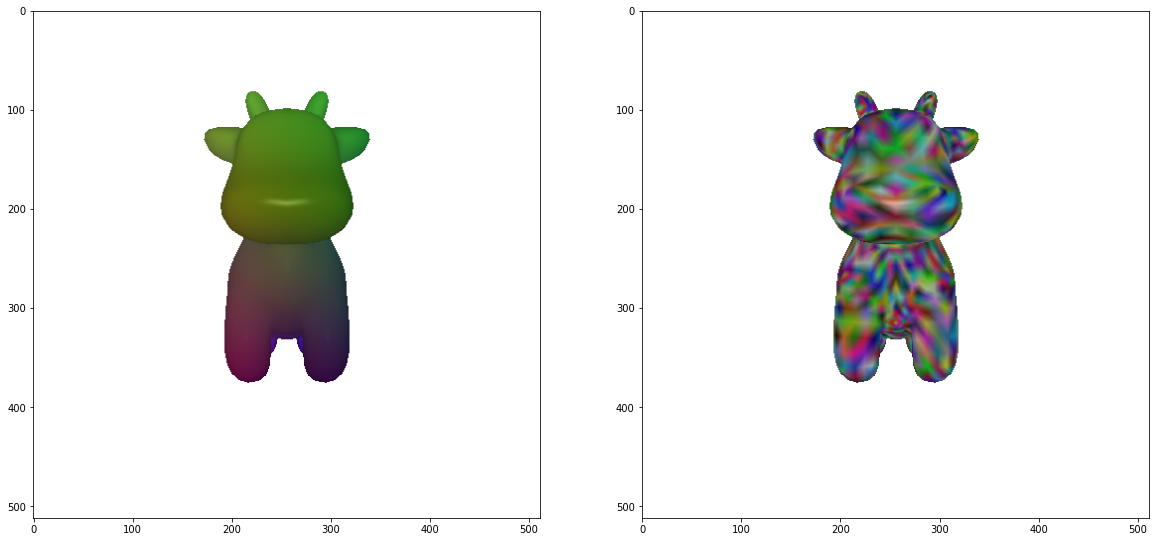

In [33]:
images = renderer(vertex_colored_mesh)
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid(False)
plt.subplot(122)
plt.imshow(images[1, ..., :3].cpu().numpy())
plt.grid(False)

### Sampling a pointcloud from a Mesh

We sample points uniformly from the mesh surface. Getting the color from the mesh's texture uses the same sample_textures function as we saw the renderer used earlier.

In [34]:
# the larger the face, the larger the probability of sampling point
points, features = sample_points_from_meshes(mesh, num_samples=20000, return_textures=True)

In [35]:
pointcloud = Pointclouds(points=points, features=features)

In [36]:
plot_batch_individually(pointcloud)

### We can plot the textured mesh alongside the pointcloud using plotly. This also illustrates indexing from the batch of meshes

In [37]:
offset_pc1 = points.new_tensor([1.0, 0, 0]).expand(points.shape[1], 3)
plot_batch_individually([pointcloud.clone().offset(offset_pc1), vertex_colored_mesh[0]])